In [37]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import gzip
import scipy.io
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
root_dir = "/projects/p31666/zzhang/doublet-bchmk/data/fatemap_data"
all_datasets_dirs = [os.path.join(root_dir, x) for x in next(os.walk(root_dir))[1]]

In [26]:
vis_df=[]
for cur_dataset_dir in all_datasets_dirs:
    dataset_id = cur_dataset_dir.split('/')[-1]
    labels_prefix = os.path.join(cur_dataset_dir, "fatemapID", dataset_id)
    dir_10X = os.path.join(cur_dataset_dir, "10X")
    sample_dirs = [os.path.join(dir_10X, x) for x in next(os.walk(dir_10X))[1]]
    for cur_sample_dir in sample_dirs:
        _, _, cur_labels_to_keep = read_fatemap(cur_sample_dir, labels_prefix)
        cur_key=cur_sample_dir.split("/")[-3]+"_"+cur_sample_dir.split("/")[-1]
        cur_count=Counter(cur_labels_to_keep)
        vis_df.append([cur_key, cur_count["multiplet"], cur_count["singlet"]])

Counts matrix shape: 5368 rows, 32738 columns
Number of genes in gene list: 32738
Estimated multiplet rate: 0.338301043219076
Counts matrix shape: 7863 rows, 32738 columns
Number of genes in gene list: 32738
Estimated multiplet rate: 0.16151596082920006
Counts matrix shape: 1 rows, 36601 columns
Number of genes in gene list: 36601
Estimated multiplet rate: 0.0
Counts matrix shape: 14 rows, 36601 columns
Number of genes in gene list: 36601
Estimated multiplet rate: 0.5714285714285714
Counts matrix shape: 2797 rows, 36601 columns
Number of genes in gene list: 36601
Estimated multiplet rate: 0.47050411154808724
Counts matrix shape: 2767 rows, 36601 columns
Number of genes in gene list: 36601
Estimated multiplet rate: 0.28586917238886883
Counts matrix shape: 9558 rows, 32738 columns
Number of genes in gene list: 32738
Estimated multiplet rate: 0.2788240217618749
Counts matrix shape: 8696 rows, 32738 columns
Number of genes in gene list: 32738
Estimated multiplet rate: 0.24298528058877644
C

In [51]:
vis_df=pd.DataFrame(vis_df)
# vis_df.columns=["Name","Multiplet","Singlet"]
# vis_df=vis_df.set_index("Name")
vis_df=vis_df[vis_df["Singlet"]>30]

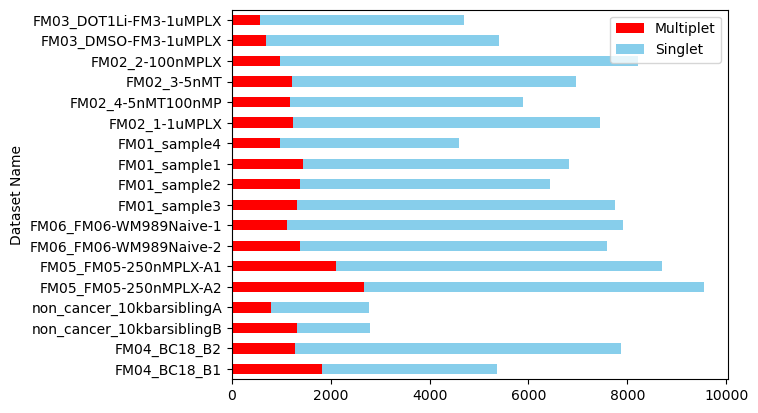

In [54]:
vis_df.plot(kind='barh', stacked=True, color=['red', 'skyblue'], ylabel="Cell Count", xlabel="Dataset Name")
plt.show()

In [9]:
def read_fatemap(prefix, cell_labels_prefix):
    cell_id_file = prefix + "/barcodes.tsv.gz"
    gene_id_file = prefix + "/features.tsv.gz"
    mtx = prefix + "/matrix.mtx.gz"
    singlets_file = cell_labels_prefix + "_singlets.txt"
    multiplets_file = cell_labels_prefix + "_multiplets.txt"

    with open(singlets_file) as fp:
        singlets = [x.strip("\n") for x in fp.readlines()]
    singlets = np.array([x + "-1" for x in singlets])
    with open(multiplets_file) as fp:
        multiplets = np.array([x.strip("\n") for x in fp.readlines()])
    multiplets = np.array([x + "-1" for x in multiplets])
    with gzip.open(cell_id_file) as fp:
        cell_ids = np.array([x.decode('UTF-8').strip("\n") for x in fp.readlines()])
    labels = ["singlet" if x in singlets else "multiplet" if x in multiplets else "NA" for x in cell_ids]
    idx_to_keep = [idx for idx, item in enumerate(labels) if item != "NA"]


    labels_to_keep = [labels[idx] for idx in idx_to_keep]
    counts_matrix = scipy.io.mmread(mtx).T.tocsc()[idx_to_keep, :]
    estimated_multiplet_rate = labels.count("multiplet") / (labels.count("multiplet") + labels.count("singlet"))

    with gzip.open(gene_id_file) as fp:
        gene_IDs = [x.decode('UTF-8').strip("\n") for x in fp.readlines()]
    print('Counts matrix shape: {} rows, {} columns'.format(counts_matrix.shape[0], counts_matrix.shape[1]))
    print('Number of genes in gene list: {}'.format(len(gene_IDs)))
    print('Estimated multiplet rate: {}'.format(estimated_multiplet_rate))

    # cur_scrub=scr.Scrublet(counts_matrix, expected_doublet_rate=estimated_multiplet_rate, random_state=2022)
    return counts_matrix, estimated_multiplet_rate, labels_to_keep